In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Фиксация random_state для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [16]:
# Загрузка очищенного датасета из ЛР-1
df = pd.read_csv('../data/raw/diabetes_clean.csv')

# Вывод основной информации о данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (768, 9)

Первые 5 строк:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.133413,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.133413,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.239130,0.133413,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.118840,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.146484,0.509202,0.479078,0.200000,1


In [17]:
# Проверка информации о данных
print("Информация о датасете:")
print(df.info())
print("\nСтатистика данных:")
df.describe()


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None

Статистика данных:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.225720,0.501205,0.493638,0.237680,0.133042,0.290299,0.162645,0.203331,0.348958
std,0.196715,0.196361,0.119355,0.080895,0.009512,0.136349,0.121945,0.193807,0.476951
min,0.000000,0.000000,0.163265,0.081522,0.118840,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.359677,0.408163,0.195652,0.129207,0.190184,0.070773,0.050000,0.000000
50%,0.176471,0.470968,0.491863,0.239130,0.133413,0.290389,0.125747,0.133333,0.000000
75%,0.352941,0.620968,0.571429,0.271739,0.136118,0.376278,0.234095,0.333333,1.000000
max,0.794118,1.000000,0.816327,0.385870,0.146484,0.655419,0.479078,0.758333,1.000000


Анализируем общую информацию о датасете - типы данных, наличие пропусков, статистические характеристики.
Это помогает понять структуру данных и выявить потенциальные проблемы, такие как выбросы или несоответствия в типах данных.

Распределение целевой переменной (Outcome):
Outcome
0    500
1    268
Name: count, dtype: int64

Доли классов:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


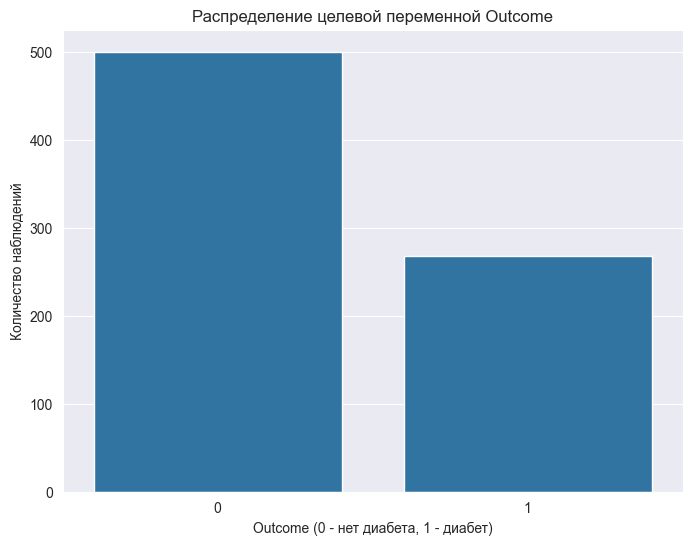

In [18]:
# Проверка баланса целевой переменной
print("Распределение целевой переменной (Outcome):")
print(df['Outcome'].value_counts())
print("\nДоли классов:")
print(df['Outcome'].value_counts(normalize=True))

# Визуализация распределения целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Outcome')
plt.title('Распределение целевой переменной Outcome')
plt.xlabel('Outcome (0 - нет диабета, 1 - диабет)')
plt.ylabel('Количество наблюдений')
plt.show()


Анализируем распределение целевой переменной для понимания баланса классов.
Это важно для выбора метрик и стратегии обучения моделей. Визуализация помогает наглядно оценить дисбаланс.

In [19]:
# Разделение на признаки и целевую переменную
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Список всех признаков (все числовые)
feature_names = X.columns.tolist()
print("Список признаков:", feature_names)


Список признаков: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Разделяем данные на матрицу признаков (X) и целевую переменную (y).
Сохраняем список всех признаков для дальнейшего использования в пайплайне и анализе.

In [20]:
# Разделяем признаки по стратегиям заполнения пропусков и нормализации
# На основе анализа данных из ЛР-1:

# Признаки с выбросами - заполняем медианой
features_median = ['SkinThickness', 'Insulin']
# Причины выбора медианы:
# - SkinThickness: 227 пропусков, имеет относительно нормальное распределение с выбросами на конце
# - Insulin: 374 пропуска, много значений близких к нулю и далеко за 400, асимметричное распределение
# Медиана устойчива к выбросам и лучше сохраняет распределение

# Признаки с нормальным распределением - заполняем средним
features_mean = ['Glucose', 'BloodPressure', 'BMI']
# Причины выбора среднего:
# - Эти признаки имеют приблизительно нормальное распределение
# - Среднее является эффективной оценкой для нормальных распределений
# - Отсутствие сильных выбросов

# Признаки без пропусков - только нормализация
features_no_missing = ['Pregnancies', 'DiabetesPedigreeFunction', 'Age']
# Причины отсутствия импьютера:
# - В очищенном датасете эти признаки не содержат пропусков
# - Pregnancies и Age - дискретные значения
# - DiabetesPedigreeFunction имеет уникальное распределение

# Создаем отдельные трансформеры для каждой группы
median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Медиана для признаков с выбросами
    ('scaler', MinMaxScaler())  # Нормализация в [0,1]
])

mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    # Среднее для нормальных распределений
    ('scaler', MinMaxScaler())  # Нормализация в [0,1]
])

no_missing_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Только нормализация для признаков без пропусков
])

# Объединение в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('median_imputer', median_transformer, features_median),
        ('mean_imputer', mean_transformer, features_mean),
        ('no_imputer', no_missing_transformer, features_no_missing)
    ])

print("Структура препроцессора создана успешно")

Структура препроцессора создана успешно



Пояснение: Создаем сложный пайплайн препроцессинга с разными стратегиями для разных групп признаков.
Это позволяет оптимально обработать данные с учетом их специфики:

    Для признаков с выбросами используем медиану (устойчива к выбросам)

    Для нормально распределенных признаков используем среднее (эффективная оценка)

    Для признаков без пропусков применяем только нормализацию
    
Такой подход минимизирует искажения данных и улучшает качество будущих моделей.

In [21]:
# Стратифицированное разбиение на train/valid/test в соотношении 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # стратификация по целевой переменной
    random_state=RANDOM_STATE
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 от 80% = 20% от общего объема
    stratify=y_temp,  # стратификация
    random_state=RANDOM_STATE
)

print("Размеры выборок:")
print(f"Обучающая выборка (train): {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Валидационная выборка (valid): {X_valid.shape[0]} samples ({X_valid.shape[0]/len(X)*100:.1f}%)")
print(f"Тестовая выборка (test): {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Размеры выборок:
Обучающая выборка (train): 460 samples (59.9%)
Валидационная выборка (valid): 154 samples (20.1%)
Тестовая выборка (test): 154 samples (20.1%)



Разбиваем данные на обучающую (60%), валидационную (20%) и тестовую (20%) выборки.
Используем стратификацию по целевой переменной для сохранения пропорций классов во всех выборках.
Это особенно важно при дисбалансе классов, чтобы модели обучались на репрезентативных данных.

In [22]:
# Обучаем пайплайн ТОЛЬКО на тренировочных данных
print("Обучение пайплайна на тренировочных данных...")
preprocessor.fit(X_train)

# Преобразуем все выборки с помощью ОБУЧЕННОГО пайплайна
X_train_processed = preprocessor.transform(X_train)
X_valid_processed = preprocessor.transform(X_valid) 
X_test_processed = preprocessor.transform(X_test)

print("Пайплайн обучен на train и применен ко всем выборкам")
print(f"Размеры обработанных данных: train {X_train_processed.shape}, valid {X_valid_processed.shape}, test {X_test_processed.shape}")

Обучение пайплайна на тренировочных данных...
Пайплайн обучен на train и применен ко всем выборкам
Размеры обработанных данных: train (460, 8), valid (154, 8), test (154, 8)


Обучаем пайплайн препроцессинга ТОЛЬКО на тренировочных данных, затем применяем его ко всем выборкам.
Это критически важно для избежания утечки данных.
Модель не должна "видеть" информацию из валидационной или тестовой выборок во время обучения препроцессора.

In [23]:
# Проверка распределения целевой переменной в разных выборках
def check_stratification(y_train, y_valid, y_test, y_original):
    """Функция для проверки стратификации"""
    original_dist = y_original.value_counts(normalize=True)
    train_dist = y_train.value_counts(normalize=True)
    valid_dist = y_valid.value_counts(normalize=True)
    test_dist = y_test.value_counts(normalize=True)
    
    stratification_check = pd.DataFrame({
        'Original': original_dist,
        'Train': train_dist,
        'Valid': valid_dist,
        'Test': test_dist
    })
    
    return stratification_check

# Проверка стратификации
strat_check = check_stratification(y_train, y_valid, y_test, y)
print("Проверка стратификации (доли классов):")
print(strat_check)

Проверка стратификации (доли классов):
         Original     Train     Valid      Test
Outcome                                        
0        0.651042  0.652174  0.649351  0.649351
1        0.348958  0.347826  0.350649  0.350649


Проверяем корректность стратификации - убеждаемся, что распределение классов сохранилось во всех выборках.
Это гарантирует, что модели будут обучаться на репрезентативных данных и оценки качества будут объективными.

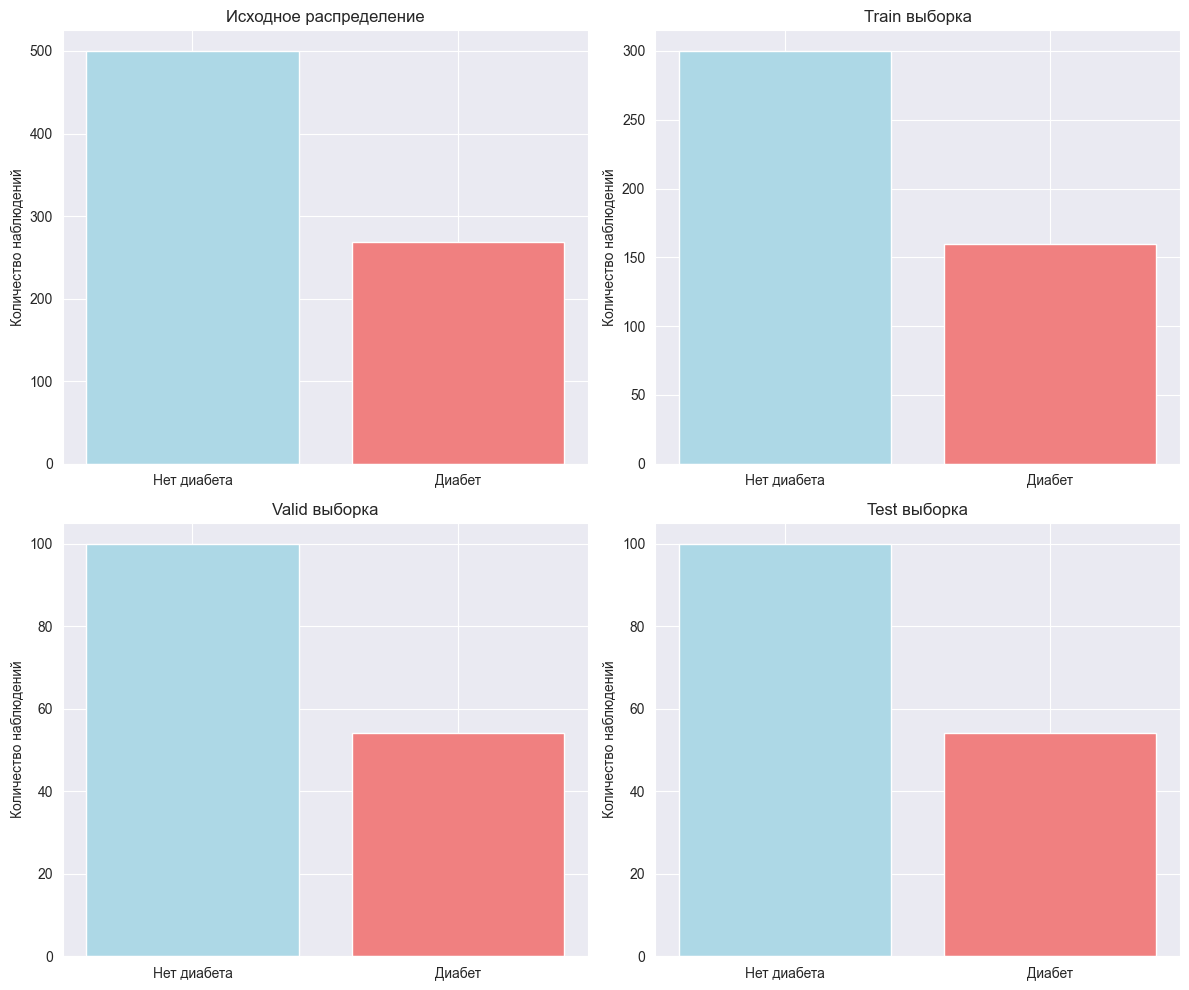

In [24]:
# Визуализация распределения классов в разных выборках (2 графика в строке)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Исходное распределение
axes[0,0].bar(['Нет диабета', 'Диабет'], [sum(y==0), sum(y==1)], color=['lightblue', 'lightcoral'])
axes[0,0].set_title('Исходное распределение')
axes[0,0].set_ylabel('Количество наблюдений')

# Train выборка
axes[0,1].bar(['Нет диабета', 'Диабет'], [sum(y_train==0), sum(y_train==1)], color=['lightblue', 'lightcoral'])
axes[0,1].set_title('Train выборка')
axes[0,1].set_ylabel('Количество наблюдений')

# Valid выборка
axes[1,0].bar(['Нет диабета', 'Диабет'], [sum(y_valid==0), sum(y_valid==1)], color=['lightblue', 'lightcoral'])
axes[1,0].set_title('Valid выборка')
axes[1,0].set_ylabel('Количество наблюдений')

# Test выборка
axes[1,1].bar(['Нет диабета', 'Диабет'], [sum(y_test==0), sum(y_test==1)], color=['lightblue', 'lightcoral'])
axes[1,1].set_title('Test выборка')
axes[1,1].set_ylabel('Количество наблюдений')

plt.tight_layout()
plt.show()

Визуализируем распределение классов во всех выборках.
Графики на русском языке с понятными подписями помогают наглядно убедиться в корректности стратификации.
Компактное расположение 2x2 облегчает сравнение распределений.

In [25]:
# Создание полного пайплайна для будущих моделей
def create_model_pipeline(model):
    """Создание полного пайплайна с препроцессингом и моделью"""
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

print("Функция для создания пайплайнов готова")

Функция для создания пайплайнов готова


Создаем универсальную функцию для быстрого создания пайплайнов с любыми моделями классификации.
Это упростит работу следующим участникам - им достаточно будет передать модель в эту функцию.

In [26]:
# Сохранение разделенных данных для следующих участников
data_split = {
    'X_train': X_train,
    'X_valid': X_valid, 
    'X_test': X_test,
    'y_train': y_train,
    'y_valid': y_valid,
    'y_test': y_test,
    'X_train_processed': X_train_processed,
    'X_valid_processed': X_valid_processed,
    'X_test_processed': X_test_processed,
    'feature_names': feature_names,
    'preprocessor': preprocessor
}

# Сохранение в файл
import pickle

with open('../data/interim/data_split.pkl', 'wb') as f:
    pickle.dump(data_split, f)

print("Разделенные данные сохранены в файл 'data_split.pkl'")

Разделенные данные сохранены в файл 'data_split.pkl'



Сохраняем все подготовленные данные и объекты в файл для передачи следующим участникам проекта.
Это обеспечивает преемственность работы и исключает необходимость повторной подготовки данных.

In [27]:
print("=" * 50)
print("ОТЧЕТ УЧАСТНИКА 1: ПОДГОТОВКА ДАННЫХ")
print("=" * 50)

print("\n✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:")
print("1. Создан репозиторий проекта (ноутбук)")
print("2. Загружен очищенный датасет из ЛР-1")
print("3. Создан sklearn Pipeline с ColumnTransformer с разными стратегиями импьютации")
print("4. Выполнено стратифицированное разбиение 60/20/20")
print("5. Зафиксирован random_state = 42")
print("6. Пайплайн обучен на train и применен ко всем выборкам")
print("7. Проверена стратификация для дисбалансных классов")
print("8. Данные сохранены для следующих участников")

print("\n📊 СТАТИСТИКА ДАННЫХ:")
print(f"Общий размер датасета: {df.shape}")
print(f"Количество признаков: {len(feature_names)}")
print(f"Размер train: {X_train.shape} ({len(y_train)/len(df)*100:.1f}%)")
print(f"Размер valid: {X_valid.shape} ({len(y_valid)/len(df)*100:.1f}%)") 
print(f"Размер test: {X_test.shape} ({len(y_test)/len(df)*100:.1f}%)")

print("\n🎯 РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
print(f"Класс 0 (нет диабета): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"Класс 1 (диабет): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")

print("\n🔧 НАСТРОЙКИ ПРЕПРОЦЕССИНГА:")
print("• SkinThickness, Insulin: импьютация медианой + нормализация (из-за выбросов)")
print("• Glucose, BloodPressure, BMI: импьютация средним + нормализация (нормальное распределение)")
print("• Pregnancies, DiabetesPedigreeFunction, Age: только нормализация (нет пропусков)")
print("• Стратификация: включена")

print("\n📁 СОХРАНЕННЫЕ ФАЙЛЫ:")
print("1. diabetes_clean.csv - исходные данные")
print("2. data_split.pkl - разделенные и обработанные данные для участников 2-5")

print("\n➡️ ДАЛЬНЕЙШИЕ ДЕЙСТВИЯ:")
print("Участник 2 может приступать к обучению базовых моделей на подготовленных данных.")

ОТЧЕТ УЧАСТНИКА 1: ПОДГОТОВКА ДАННЫХ

✅ ВЫПОЛНЕННЫЕ ЗАДАЧИ:
1. Создан репозиторий проекта (ноутбук)
2. Загружен очищенный датасет из ЛР-1
3. Создан sklearn Pipeline с ColumnTransformer с разными стратегиями импьютации
4. Выполнено стратифицированное разбиение 60/20/20
5. Зафиксирован random_state = 42
6. Пайплайн обучен на train и применен ко всем выборкам
7. Проверена стратификация для дисбалансных классов
8. Данные сохранены для следующих участников

📊 СТАТИСТИКА ДАННЫХ:
Общий размер датасета: (768, 9)
Количество признаков: 8
Размер train: (460, 8) (59.9%)
Размер valid: (154, 8) (20.1%)
Размер test: (154, 8) (20.1%)

🎯 РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:
Класс 0 (нет диабета): 500 (65.1%)
Класс 1 (диабет): 268 (34.9%)

🔧 НАСТРОЙКИ ПРЕПРОЦЕССИНГА:
• SkinThickness, Insulin: импьютация медианой + нормализация (из-за выбросов)
• Glucose, BloodPressure, BMI: импьютация средним + нормализация (нормальное распределение)
• Pregnancies, DiabetesPedigreeFunction, Age: только нормализация (нет пр